# Overview

* Use labeled samples only from the source domain
* Try to find a shared feature representatio by using unlabeled samples from both domains through self-supervised tasks
* One model uses the three self-supervised tasks, namely Rotation, Time-Segment, and Band detection tasks.
* Another model additionally uses the domain detection task, which performs much better.
* Make a base model without any self-supervised tasks and train it on source domain.
* Evaluate the performance on target domain and compare the results.

# <font color='bronze'>Note:</font>

* Due to lack of memory on my system, I partitioned the dataset after making self-supervised tasks, and read them piece by piece from the hard disk to feed them into the model. Tensorflow data loader was slower. I haven't uploaded this huge partitioned dataset since it can be generated by code from the original data.

* If you have enough RAM, this is how you should prepare the self-supervised task:

```Python
x_source = np.load('../data/source/x_test.npy') # this is named x_test because it was the test set in few-shot.
y_source = np.load('../data/source/y_test.npy')
x_target = np.load('../data/target/x_target.npy')
y_target = np.load('../data/target/y_target.npy')

# The helper functions are in utils.py
X, y_cls, y_bands, y_seg, y_rot, y_dom = prepare_all_auxiliary_dataset(x_source.copy(), y_source.copy(), x_target)

# shuffle
dummy_indx = np.random.permutation(X.shape[0])
X = X[dummy_indx]
y_cls = y_cls[dummy_indx]
y_bands = y_bands[dummy_indx]
y_seg = y_seg[dummy_indx]
y_rot = y_rot[dummy_indx]
y_dom = y_dom[dummy_indx]
del dummy_indx
```

* Then, you can forget the manual training below and just use fit API for the self-supervised models. for example:

```Python
model = get_aux_model()
# Custom losses and metrics are defined in utils.py
crop_loss_fn = MaskedCXE(ignore=4)
seg_loss_fn = MaskedCXE(ignore=5)
rot_loss_fn = MaskedBXE()
band_loss_fn = MaskedCXE(ignore=7)
dom_loss_fn = MaskedBXE()
crop_acc_metric = MaskedCategoricalAccuracyMetric(ignore=4, name='acc')
seg_acc_metric = MaskedCategoricalAccuracyMetric(ignore=5, name='acc')
rot_acc_metric = MaskedBinaryAccuracyMetric(name='acc')
band_acc_metric = MaskedCategoricalAccuracyMetric(ignore=7, name='acc')
dom_acc_metric = MaskedBinaryAccuracyMetric(name='acc')
model.compile(optimizer='adam', loss=[crop_loss_fn, band_loss_fn, seg_loss_fn, rot_loss_fn, dom_loss_fn], metrics=[[crop_acc_metric], [band_acc_metric], [seg_acc_metric], [rot_acc_metric], [dom_acc_metric]])
model.fit(X, [y_cls, y_bands, y_seg, y_rot, y_dom], epochs=300, batch_size=2**14, verbose=0,
          callbacks=[TqdmCallback(batch_size=2**14, epochs=300, data_size=X.shape[0])])
```

In [1]:
from utils import *

Tensorflow Version:  2.1.0
Numpy Version:  1.19.2


# <font color='bronze'>Self-supervised Domain Adaptation</font>

* Mix the samples from both domains(without labels).
* Make self-supervised tasks from this joint data set.
* Crop classification, Band detection, Time-segment detection, and Rotation Detection have been used together.

In [2]:
def get_aux_model():
    tf.keras.backend.clear_session()
    input_x = layers.Input(shape=[10, 7], name='input_x')
    # trunc: shared part of the model
    shared_x = layers.Conv1D(32, 1, name='conv_1')(input_x)
    shared_x = layers.BatchNormalization(name='bn_1')(shared_x)
    shared_x = layers.LeakyReLU(name='act_1')(shared_x)
    shared_x = layers.LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True, name='lstm_1')(shared_x)
    shared_x = layers.LSTM(64, return_sequences=False, name='lstm_2')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_2')(shared_x)
    shared_x = layers.Dense(32, name='dense_1')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_3')(shared_x)
    shared_x = layers.LeakyReLU(name='act_2')(shared_x)
    shared_x = layers.Dropout(0.25, name='drop_1')(shared_x)

    # head 1 --> tell the sample time-segment partition.
    seg_x = layers.Dense(5, activation='softmax', name='out_seg')(shared_x)

    # head 2 --> tell the sample band channel
    ban_x = layers.Dense(7, activation='softmax', name='out_band')(shared_x)

    # head 3 --> tell the sample rotation
    rot_x = layers.Dense(1, activation='sigmoid', name='out_rot')(shared_x)

    # head 4 --> main classifier for crop
    cls_x = layers.Dense(4, activation='softmax', name='out_cls')(shared_x)

    model = tf.keras.Model(inputs=input_x, outputs=[cls_x, ban_x, seg_x, rot_x])
    return model

In [5]:
aux_model = get_aux_model()

In [6]:
EPOCHS = 300
batch = 2**15
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss functions
crop_loss_fn = MaskedCXE(ignore=4)
seg_loss_fn = MaskedCXE(ignore=5)
rot_loss_fn = MaskedBXE()
band_loss_fn = MaskedCXE(ignore=7)
# metrics
crop_acc_metric = MaskedCategoricalAccuracyMetric(ignore=4)
seg_acc_metric = MaskedCategoricalAccuracyMetric(ignore=5)
rot_acc_metric = MaskedBinaryAccuracyMetric()
band_acc_metric = MaskedCategoricalAccuracyMetric(ignore=7)

@tf.function
def train_step(x, y_c, y_b, y_s, y_r):
    with tf.GradientTape() as tape:
        y_pred_crop, y_pred_band, y_pred_seg, y_pred_rot = aux_model(x, training=True)
        crop_loss = crop_loss_fn(y_c, y_pred_crop)
        seg_loss = seg_loss_fn(y_s, y_pred_seg)
        rot_loss = rot_loss_fn(y_r, y_pred_rot)
        band_loss = band_loss_fn(y_b, y_pred_band)
        total_loss = crop_loss + band_loss + seg_loss + rot_loss + sum(aux_model.losses)
    grads = tape.gradient(total_loss, aux_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, aux_model.trainable_variables))
    crop_acc_metric.update_state(y_c, y_pred_crop)
    seg_acc_metric.update_state(y_s, y_pred_seg)
    rot_acc_metric.update_state(y_r, y_pred_rot)
    band_acc_metric.update_state(y_b, y_pred_band)
    return seg_loss, band_loss, rot_loss, crop_loss

In [7]:
crop_losses = []
seg_losses = []
rot_losses = []
band_losses = []
progress = {'crop_loss':[], 'band_loss':[], 'seg_loss':[], 'rot_loss':[],
            'crop_acc':[], 'band_acc':[], 'seg_acc':[], 'rot_acc':[]}

start_time = time.time()
for epoch in range(EPOCHS):
    
    epoch_start_time = time.time()
    
    #!! you don't have this partionoed data unless you generate and partion it yourself(it's huge!)
    # please refer to the note at the begining of this notebook to see what to do
    for part in range(10):
        X = np.load('data_partition_aux/'+'X'+str(part)+'.npy')
        y_cls = np.load('data_partition_aux/'+'y_cls'+str(part)+'.npy')
        y_bands = np.load('data_partition_aux/'+'y_bands'+str(part)+'.npy')
        y_seg = np.load('data_partition_aux/'+'y_seg'+str(part)+'.npy')
        y_rot = np.load('data_partition_aux/'+'y_rot'+str(part)+'.npy')
        
        # shuffle
        dummy_indx = np.random.permutation(X.shape[0])
        X = X[dummy_indx]
        y_cls = y_cls[dummy_indx]
        y_bands = y_bands[dummy_indx]
        y_seg = y_seg[dummy_indx]
        y_rot = y_rot[dummy_indx]

        for i in range(X.shape[0] // batch):

            x_batch_train = tf.convert_to_tensor(X[i*batch:(i+1)*batch], dtype=tf.float32)
            y_batch_train_crop = tf.convert_to_tensor(y_cls[i*batch:(i+1)*batch], dtype=tf.float32)
            y_batch_train_band = tf.convert_to_tensor(y_bands[i*batch:(i+1)*batch], dtype=tf.float32)
            y_batch_train_seg = tf.convert_to_tensor(y_seg[i*batch:(i+1)*batch], dtype=tf.float32)
            y_batch_train_rot = tf.convert_to_tensor(y_rot[i*batch:(i+1)*batch], dtype=tf.float32)

            seg_train_loss, band_train_loss, rot_train_loss, crop_train_loss = \
            train_step(x_batch_train, y_batch_train_crop, y_batch_train_band, y_batch_train_seg, y_batch_train_rot)

            crop_losses.append(crop_train_loss)
            band_losses.append(band_train_loss)
            seg_losses.append(seg_train_loss)
            rot_losses.append(rot_train_loss)

    # Handling metrics and progress
    # losses
    progress['crop_loss'].append(np.mean(crop_losses))
    progress['band_loss'].append(np.mean(band_losses))
    progress['seg_loss'].append(np.mean(seg_losses))
    progress['rot_loss'].append(np.mean(rot_losses))
    # accuracies
    progress['crop_acc'].append(crop_acc_metric.result().numpy())
    progress['band_acc'].append(band_acc_metric.result().numpy())
    progress['seg_acc'].append(seg_acc_metric.result().numpy())
    progress['rot_acc'].append(rot_acc_metric.result().numpy())
    
    # reset metrics for the next epoch
    crop_losses = []
    band_losses = []
    seg_losses = []
    rot_losses = []
    crop_acc_metric.reset_states()
    band_acc_metric.reset_states()
    seg_acc_metric.reset_states()
    rot_acc_metric.reset_states()
    
    print('training...')
    print(epoch+1, '/', EPOCHS)
    print("Crop training accuracy: %.4f" % (progress['crop_acc'][-1],))
    print("Band training accuracy: %.4f" % (progress['band_acc'][-1],))
    print("Time-Segment training accuracy: %.4f" % (progress['seg_acc'][-1],))
    print("Rotation training accuracy: %.4f" % (progress['rot_acc'][-1],))
    print("Time taken: %.2fs" % (time.time() - epoch_start_time))
    clear_output(wait=True)

print("Crop training accuracy: %.4f" % (progress['crop_acc'][-1],))
print("Band training accuracy: %.4f" % (progress['band_acc'][-1],))
print("Time-Segment training accuracy: %.4f" % (progress['seg_acc'][-1],))
print("Rotation training accuracy: %.4f" % (progress['rot_acc'][-1],))
print("Total training time: %.2fs" % (time.time() - start_time))     

Crop training accuracy: 0.9892
Band training accuracy: 0.9010
Time-Segment training accuracy: 0.9664
Rotation training accuracy: 0.9999
Total training time: 68357.74s


In [8]:
np.save('no_grl_weights_300epochs/no_grl_weights_300epochs.npy', np.array(aux_model.get_weights(), dtype=object))

In [10]:
x_target = np.load('../data/target/x_target.npy')
y_target = np.load('../data/target/y_target.npy')

              precision    recall  f1-score   support

       wheat       0.29      0.17      0.22     39000
        corn       0.38      0.87      0.53    300000
        rice       0.90      0.48      0.62    300000
       other       0.25      0.05      0.09    300000

    accuracy                           0.46    939000
   macro avg       0.46      0.39      0.36    939000
weighted avg       0.50      0.46      0.41    939000



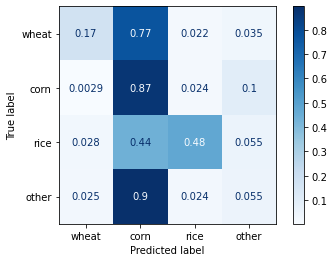

0.4555953141640043

In [11]:
# This is the performance on target domain
test_aux_tasks_model_no_dom(x_target, y_target, model=aux_model, name='CM_DA_no_grl_300epochs.png')

# <font color='bronze'>Self-supervised Domain Adaptation with Domain Detection Task</font>

* Same as the previous model but enhanced with domain detection task.
* Use gradient reversal layer to pull feature representation of domains closer to each others.
* Crop classification, Band detection, Time-segment detection, Rotation Detection, and Domain detection with Gradient Reversal Layer have been used together.

In [2]:
def get_grl_model():
    tf.keras.backend.clear_session()
    input_x = layers.Input(shape=[10, 7], name='input_x')
    # trunc: shared part of the model
    shared_x = layers.Conv1D(32, 1, name='conv_1')(input_x)
    shared_x = layers.BatchNormalization(name='bn_1')(shared_x)
    shared_x = layers.LeakyReLU(name='act_1')(shared_x)
    shared_x = layers.LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True, name='lstm_1')(shared_x)
    shared_x = layers.LSTM(64, return_sequences=False, name='lstm_2')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_2')(shared_x)
    shared_x = layers.Dense(32, name='dense_1')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_3')(shared_x)
    shared_x = layers.LeakyReLU(name='act_2')(shared_x)
    shared_x = layers.Dropout(0.25, name='drop_1')(shared_x)

    # head 1 --> tell the sample time-segment partition.
    seg_x = layers.Dense(5, activation='softmax', name='out_seg')(shared_x)

    # head 2 --> tell the sample band channel
    ban_x = layers.Dense(7, activation='softmax', name='out_band')(shared_x)

    # head 3 --> tell the sample rotation
    rot_x = layers.Dense(1, activation='sigmoid', name='out_rot')(shared_x)

    # head 4 --> main classifier for crop
    cls_x = layers.Dense(4, activation='softmax', name='out_cls')(shared_x)

    # head 5 --> tell the samples' domain
    dom_x = GradientReversalLayer()(shared_x)
    dom_x = layers.Dense(32, name='dense_dom_1')(dom_x)
    dom_x = layers.BatchNormalization(name='bn_dom_1')(dom_x)
    dom_x = layers.LeakyReLU(name='act_dom_1')(dom_x)
    dom_x = layers.Dropout(0.25, name='drop_dom_1')(dom_x)
    dom_x = layers.Dense(16, name='dense_dom_2')(dom_x)
    dom_x = layers.BatchNormalization(name='bn_dom_2')(dom_x)
    dom_x = layers.LeakyReLU(name='act_dom_2')(dom_x)
    dom_x = layers.Dense(1, activation='sigmoid', name='out_dom')(dom_x)

    model = tf.keras.Model(inputs=input_x, outputs=[cls_x, ban_x, seg_x, rot_x, dom_x])
    return model

In [3]:
grl_model = get_grl_model()

In [4]:
EPOCHS = 300
batch = 2**15
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss functions
crop_loss_fn = MaskedCXE(ignore=4)
seg_loss_fn = MaskedCXE(ignore=5)
rot_loss_fn = MaskedBXE()
band_loss_fn = MaskedCXE(ignore=7)
dom_loss_fn = MaskedBXE()
# metrics
crop_acc_metric = MaskedCategoricalAccuracyMetric(ignore=4)
seg_acc_metric = MaskedCategoricalAccuracyMetric(ignore=5)
rot_acc_metric = MaskedBinaryAccuracyMetric()
band_acc_metric = MaskedCategoricalAccuracyMetric(ignore=7)
dom_acc_metric = MaskedBinaryAccuracyMetric()

@tf.function
def train_step(x, y_c, y_b, y_s, y_r, y_d):
    with tf.GradientTape() as tape:
        y_pred_crop, y_pred_band, y_pred_seg, y_pred_rot, y_pred_dom = grl_model(x, training=True)
        crop_loss = crop_loss_fn(y_c, y_pred_crop)
        seg_loss = seg_loss_fn(y_s, y_pred_seg)
        rot_loss = rot_loss_fn(y_r, y_pred_rot)
        band_loss = band_loss_fn(y_b, y_pred_band)
        dom_loss = dom_loss_fn(y_d, y_pred_dom)
        total_loss = crop_loss + band_loss + seg_loss + rot_loss + dom_loss + sum(grl_model.losses)
    grads = tape.gradient(total_loss, grl_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, grl_model.trainable_variables))
    crop_acc_metric.update_state(y_c, y_pred_crop)
    seg_acc_metric.update_state(y_s, y_pred_seg)
    rot_acc_metric.update_state(y_r, y_pred_rot)
    band_acc_metric.update_state(y_b, y_pred_band)
    dom_acc_metric.update_state(y_d, y_pred_dom)
    return seg_loss, band_loss, rot_loss, crop_loss, dom_loss

In [5]:
crop_losses = []
seg_losses = []
rot_losses = []
band_losses = []
dom_losses = []
progress = {'crop_loss':[], 'band_loss':[], 'seg_loss':[], 'rot_loss':[], 'dom_loss':[],
            'crop_acc':[], 'band_acc':[], 'seg_acc':[], 'rot_acc':[], 'dom_acc':[]}

start_time = time.time()
for epoch in range(EPOCHS):
    
    epoch_start_time = time.time()
    
    for part in range(10):
        X = np.load('data_partition_grl/'+'X'+str(part)+'.npy')
        y_cls = np.load('data_partition_grl/'+'y_cls'+str(part)+'.npy')
        y_bands = np.load('data_partition_grl/'+'y_bands'+str(part)+'.npy')
        y_seg = np.load('data_partition_grl/'+'y_seg'+str(part)+'.npy')
        y_rot = np.load('data_partition_grl/'+'y_rot'+str(part)+'.npy')
        y_dom = np.load('data_partition_grl/'+'y_dom'+str(part)+'.npy')
        
        # shuffle
        dummy_indx = np.random.permutation(X.shape[0])
        X = X[dummy_indx]
        y_cls = y_cls[dummy_indx]
        y_bands = y_bands[dummy_indx]
        y_seg = y_seg[dummy_indx]
        y_rot = y_rot[dummy_indx]
        y_dom = y_dom[dummy_indx]
        
        for i in range(X.shape[0] // batch):

            x_batch_train = tf.convert_to_tensor(X[i*batch:(i+1)*batch], dtype=tf.float32)
            y_batch_train_crop = tf.convert_to_tensor(y_cls[i*batch:(i+1)*batch], dtype=tf.float32)
            y_batch_train_band = tf.convert_to_tensor(y_bands[i*batch:(i+1)*batch], dtype=tf.float32)
            y_batch_train_seg = tf.convert_to_tensor(y_seg[i*batch:(i+1)*batch], dtype=tf.float32)
            y_batch_train_rot = tf.convert_to_tensor(y_rot[i*batch:(i+1)*batch], dtype=tf.float32)
            y_batch_train_dom = tf.convert_to_tensor(y_dom[i*batch:(i+1)*batch], dtype=tf.float32)

            seg_train_loss, band_train_loss, rot_train_loss, crop_train_loss, dom_train_loss = \
            train_step(x_batch_train, y_batch_train_crop, y_batch_train_band, y_batch_train_seg,
                       y_batch_train_rot, y_batch_train_dom)

            crop_losses.append(crop_train_loss)
            band_losses.append(band_train_loss)
            seg_losses.append(seg_train_loss)
            rot_losses.append(rot_train_loss)
            dom_losses.append(dom_train_loss)

    # Handling metrics and progress
    # losses
    progress['crop_loss'].append(np.mean(crop_losses))
    progress['band_loss'].append(np.mean(band_losses))
    progress['seg_loss'].append(np.mean(seg_losses))
    progress['rot_loss'].append(np.mean(rot_losses))
    progress['dom_loss'].append(np.mean(dom_losses))
    # accuracies
    progress['crop_acc'].append(crop_acc_metric.result().numpy())
    progress['band_acc'].append(band_acc_metric.result().numpy())
    progress['seg_acc'].append(seg_acc_metric.result().numpy())
    progress['rot_acc'].append(rot_acc_metric.result().numpy())
    progress['dom_acc'].append(dom_acc_metric.result().numpy())    
    
    # reset metrics for the next epoch
    crop_losses = []
    band_losses = []
    seg_losses = []
    rot_losses = []
    dom_losses = []
    crop_acc_metric.reset_states()
    band_acc_metric.reset_states()
    seg_acc_metric.reset_states()
    rot_acc_metric.reset_states()
    dom_acc_metric.reset_states()
    
    print('training...')
    print(epoch+1, '/', EPOCHS)
    print("Crop training accuracy: %.4f" % (progress['crop_acc'][-1],))
    print("Band training accuracy: %.4f" % (progress['band_acc'][-1],))
    print("Time-Segment training accuracy: %.4f" % (progress['seg_acc'][-1],))
    print("Rotation training accuracy: %.4f" % (progress['rot_acc'][-1],))
    print("Domain training accuracy: %.4f" % (progress['dom_acc'][-1],))
    print("Time taken: %.2fs" % (time.time() - epoch_start_time))
    clear_output(wait=True)
    np.save('grl_weights_300epochs/weights_grl_'+str(epoch+1)+'.npy', np.array(grl_model.get_weights(), dtype=object))
        
print("Crop training accuracy: %.4f" % (progress['crop_acc'][-1],))
print("Band training accuracy: %.4f" % (progress['band_acc'][-1],))
print("Time-Segment training accuracy: %.4f" % (progress['seg_acc'][-1],))
print("Rotation training accuracy: %.4f" % (progress['rot_acc'][-1],))
print("Domain training accuracy: %.4f" % (progress['dom_acc'][-1],))
print("Total training time: %.2fs" % (time.time() - start_time))

Crop training accuracy: 0.9895
Band training accuracy: 0.8993
Time-Segment training accuracy: 0.9665
Rotation training accuracy: 0.9999
Domain training accuracy: 0.5610
Total training time: 102783.93s


In [6]:
x_target = np.load('../data/target/x_target.npy')
y_target = np.load('../data/target/y_target.npy')

              precision    recall  f1-score   support

       wheat       0.12      0.80      0.21     39000
        corn       0.86      0.61      0.71    300000
        rice       0.98      0.76      0.86    300000
       other       0.98      0.75      0.85    300000

    accuracy                           0.71    939000
   macro avg       0.74      0.73      0.66    939000
weighted avg       0.91      0.71      0.78    939000



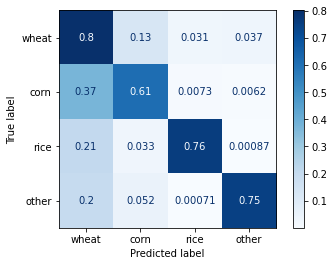

0.7105793397231097

In [7]:
# This is the accuracy on target domain(much better, it works!)
test_aux_tasks_model(x_target, y_target, grl_model, name='CM_DA_grl_300epochs.png')

# <font color='bronze'>Baseline</font>

* Let's see how a simple model without any self-supervision performs.

In [2]:
x_source = np.load('../data/source/x_src.npy')
y_source = np.load('../data/source/y_src.npy')
x_target = np.load('../data/target/x_target.npy')
y_target = np.load('../data/target/y_target.npy')

print('Source Domain')
print('Training set class frequencies:\t\t', '#Wheat\t', '#Corn\t', '#Rice\t', '#Other')
f = np.bincount(y_source.astype('int32'))
print(f'\t\t\t\t\t {f[0]}', f' {f[1]}', f' {f[2]}', f' {f[3]}')
print()
print('Target Domain')
print('class frequencies:\t\t\t', '#Wheat\t', '#Corn\t', '#Rice\t', '#Other')
f = np.bincount(y_target.astype('int32'))
print(f'\t\t\t\t\t {f[0]}', f'  {f[1]}', f' {f[2]}', f' {f[3]}')

Source Domain
Training set class frequencies:		 #Wheat	 #Corn	 #Rice	 #Other
					 300000  300000  300000  300000

Target Domain
class frequencies:			 #Wheat	 #Corn	 #Rice	 #Other
					 39000   300000  300000  300000


In [3]:
base_model = tf.keras.Sequential([
        layers.Input(shape=(10, 7)),
        layers.Conv1D(32, 1, name='conv_1'),
        layers.BatchNormalization(name='bn_1'),
        layers.LeakyReLU(name='act_1'),
        layers.LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True, name='lstm_1'),
        layers.LSTM(64, return_sequences=False, name='lstm_2'),
        layers.BatchNormalization(name='bn_2'),
        layers.Dense(32, name='dense_1'),
        layers.BatchNormalization(name='bn_3'),
        layers.LeakyReLU(name='act_2'),
        layers.Dropout(0.25, name='drop_1'),
        layers.Dense(4, activation='softmax', name='out')
    ])
base_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [4]:
history = base_model.fit(x_source, y_source, epochs=300, batch_size=2**14, verbose=0,
              callbacks=[TqdmCallback(epochs=300, batch_size=2**14, data_size=x_source.shape[0])])

              precision    recall  f1-score   support

       wheat       0.50      0.49      0.49     39000
        corn       0.51      0.82      0.63    300000
        rice       0.43      0.60      0.50    300000
       other       0.66      0.01      0.02    300000

    accuracy                           0.48    939000
   macro avg       0.53      0.48      0.41    939000
weighted avg       0.53      0.48      0.39    939000



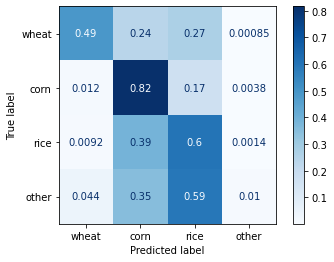

0.4765825346112886

In [5]:
# it sucks as expected. still better than self-supervised without domain detection task!!
test_base_model(x_target, y_target, model=base_model, save_name='CM_DA_base_300epochs.png')

# <font color='bronze'>Baseline + Domain Detection and GRL</font>

* Let's see then if other self-supervised tasks are necessary or not. I'm just using the domain detection task here.

In [3]:
X, y_cls, y_dom = prepare_only_domain_baseline_dataset(x_source.copy(), y_source.copy(), x_target)
dummy = np.random.permutation(X.shape[0])
X = X[dummy]
y_cls = y_cls[dummy]
y_dom = y_dom[dummy]
del dummy

In [4]:
print(X.shape,'\n', y_cls.shape,'\n',y_dom.shape,'\n',np.bincount(y_cls.astype('int32')),\
      '\n',np.bincount(y_dom.astype('int32')))

(3339000, 10, 7) 
 (3339000,) 
 (3339000,) 
 [ 300000  300000  300000  300000 2139000] 
 [1200000  939000 1200000]


In [5]:
input_x = layers.Input(shape=[10, 7], name='input_x')
# trunc: shared part of the model
shared_x = layers.Conv1D(32, 1, name='conv_1')(input_x)
shared_x = layers.BatchNormalization(name='bn_1')(shared_x)
shared_x = layers.LeakyReLU(name='act_1')(shared_x)
shared_x = layers.LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True, name='lstm_1')(shared_x)
shared_x = layers.LSTM(64, return_sequences=False, name='lstm_2')(shared_x)
shared_x = layers.BatchNormalization(name='bn_2')(shared_x)
shared_x = layers.Dense(32, name='dense_1')(shared_x)
shared_x = layers.BatchNormalization(name='bn_3')(shared_x)
shared_x = layers.LeakyReLU(name='act_2')(shared_x)
shared_x = layers.Dropout(0.25, name='drop_1')(shared_x)

# head 1 --> main classifier for crop
cls_x = layers.Dense(4, activation='softmax', name='out_cls')(shared_x)
    
# head 2 --> tell the sample domain
dom_x = GradientReversalLayer()(shared_x)
dom_x = layers.Dense(32, name='dense_dom_1')(dom_x)
dom_x = layers.BatchNormalization(name='bn_dom_1')(dom_x)
dom_x = layers.LeakyReLU(name='act_dom_1')(dom_x)
dom_x = layers.Dropout(0.25, name='drop_dom_1')(dom_x)
dom_x = layers.Dense(16, name='dense_dom_2')(dom_x)
dom_x = layers.BatchNormalization(name='bn_dom_2')(dom_x)
dom_x = layers.LeakyReLU(name='act_dom_2')(dom_x)
dom_x = layers.Dense(1, activation='sigmoid', name='out_dom')(dom_x)

model = tf.keras.Model(inputs=input_x, outputs=[cls_x, dom_x])

crop_loss_fn = MaskedCXE(ignore=4)
dom_loss_fn = MaskedBXE()
crop_acc_metric = MaskedCategoricalAccuracyMetric(ignore=4, name='acc')
dom_acc_metric = MaskedBinaryAccuracyMetric(name='acc')

model.compile(optimizer='adam', loss=[crop_loss_fn, dom_loss_fn], metrics=[[crop_acc_metric], [dom_acc_metric]])

In [6]:
model.fit(X, [y_cls, y_dom], epochs=300, batch_size=2**14, verbose=0,
          callbacks=[TqdmCallback(batch_size=2**14, epochs=300, data_size=X.shape[0])])

              precision    recall  f1-score   support

       wheat       0.12      0.82      0.21     39000
        corn       0.66      0.62      0.64    300000
        rice       0.95      0.70      0.81    300000
       other       0.34      0.19      0.24    300000

    accuracy                           0.52    939000
   macro avg       0.52      0.58      0.48    939000
weighted avg       0.63      0.52      0.55    939000



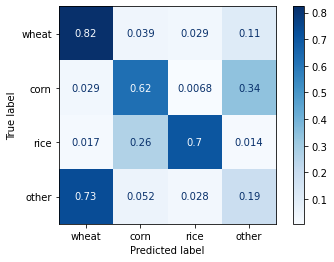

0.5180010649627264

In [7]:
test_aux_tasks_model_only_domain(x_target, y_target, model, name='CM_DA_baseline_only_dom_task_300epochs.png')

# <font color='green'>Conclusion</font>:

* A baseline model without any task performed better than the self-supervised tasks without domain detection.
* Adding domain detection to baseline improved the performance a bit.
* Most interesting result is that when we use domain detection task along with other self-supervised tasks, then they become much more powerful.
* Hence, we should use self-supervised tasks but the domain adaptation task must be present.
* We improved the accuracy by about 24%.